# Smoothness
---
The purpose of this notebook is to compute the smoothness of several model parameterization outputs w.r.t. some generated teacher outputs.

## Notebook configuration
Configure several notebook configuration settings.

In [1]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore')
# warnings.filterwarnings('ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

Disable autoscrolling for better visualization of results:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [3]:
# Miscellaneous libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# Setup some options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100


# Visualization
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

## Utility functions
---
Define some utility functions that will be used later for fetching data and ploting.

In [4]:
# Define some auxiliary functions for reading the generated smoothness csv files
def readSmoothnessCSV(smoothness_filename):
    '''Auxiliary function to read a generated smoothness csv file.'''
    smoothness_stats = (pd.read_csv(smoothness_filename, header=[0, 1, 2], index_col=[0, 1]))
    return smoothness_stats

## Fetching data to analyze
---
Fetch all the generated `smoothness` csv files generated and analyze them.

In [101]:
!ls "../../data/synthetic/erdos_renyi"

N100_n100_p0.1_1625478135 N100_n100_p0.1_1625907336 N100_n100_p0.1_1625907390
N100_n100_p0.1_1625733973 N100_n100_p0.1_1625907363 N110_n100_p0.1_1626075392
N100_n100_p0.1_1625821111 N100_n100_p0.1_1625907371 N300_n100_p0.1_1624629108
N100_n100_p0.1_1625907301 N100_n100_p0.1_1625907378
N100_n100_p0.1_1625907313 N100_n100_p0.1_1625907384


In [5]:
dataset_prefix = '../../data/synthetic/erdos_renyi'

all_datasets = [
    x for x in os.listdir(dataset_prefix) 
    if all([c.isdigit() for c in x[-10:]]) and int(x[-10:]) >= 1625907301 and int(x[-10:]) <= 1625907390
]

N_SIZES = [105, 110, 115, 120, 125, 130, 140, 150]
TEACHER_CONFIG = 'hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1'
DIST_MATRIX = 'WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64'

# Gather all results for a given fixed teacher parameterization and a fixed distance matrix for computing the smoothness
smoothness_stats_avg = pd.DataFrame()
for n_size, dataset in zip(N_SIZES, sorted(all_datasets)):
    teacher_outputs_prefix = f'{dataset_prefix}/{dataset}/teacher_outputs/regression/GIN/{TEACHER_CONFIG}'
    teacher_outputs_filenames = [x for x in os.listdir(teacher_outputs_prefix) if all([c.isdigit() for c in x])]
    for teacher_outputs_filename in teacher_outputs_filenames:
        student_outputs_filename = \
            f"{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness/{DIST_MATRIX}.csv"
        smoothness_stats = readSmoothnessCSV(student_outputs_filename)
        # Filter only extrapolation data
        smoothness_stats = smoothness_stats.iloc[:, smoothness_stats.columns.get_level_values(1) == 'extrapolation']
        smoothness_stats.columns = smoothness_stats.columns.droplevel(1)
        # Filter only smoothness and rmse data (no std dev)
        smoothness_stats = smoothness_stats.iloc[:, smoothness_stats.columns.get_level_values(1).isin(['mean_smoothness', 'mean_rmse'])]
        smoothness_stats_ = smoothness_stats.copy()
        smoothness_stats_ = smoothness_stats_.iloc[:, smoothness_stats_.columns.get_level_values(0) == '10']
        smoothness_stats_.columns = smoothness_stats_.columns.droplevel(0)
        smoothness_stats_.loc[smoothness_stats_.index.get_level_values(0).isin(['Real', 'Baseline']), ['mean_smoothness', 'mean_rmse']] = \
            smoothness_stats.loc[smoothness_stats.index.get_level_values(0).isin(['Real', 'Baseline']), smoothness_stats.columns.get_level_values(0) == '0'].droplevel(0, axis=1)
        smoothness_stats_ = smoothness_stats_.reset_index().rename(columns={'level_0': 'model', 'level_1': 'model_config'})
        # Append value of N (for extrapolation)
        smoothness_stats_['n'] = [n_size] * len(smoothness_stats)
        # Reorder columns
        smoothness_stats_ = smoothness_stats_[['n', 'model', 'model_config', 'mean_smoothness', 'mean_rmse']]
        smoothness_stats_avg = smoothness_stats_avg.append(smoothness_stats_)


# Average the results throughout the different teacher initializations.
smoothness_stats_avg = smoothness_stats_avg.groupby(['n', 'model', 'model_config']).mean().reset_index()
smoothness_stats_avg

KeyError: 'n'

## Visualization

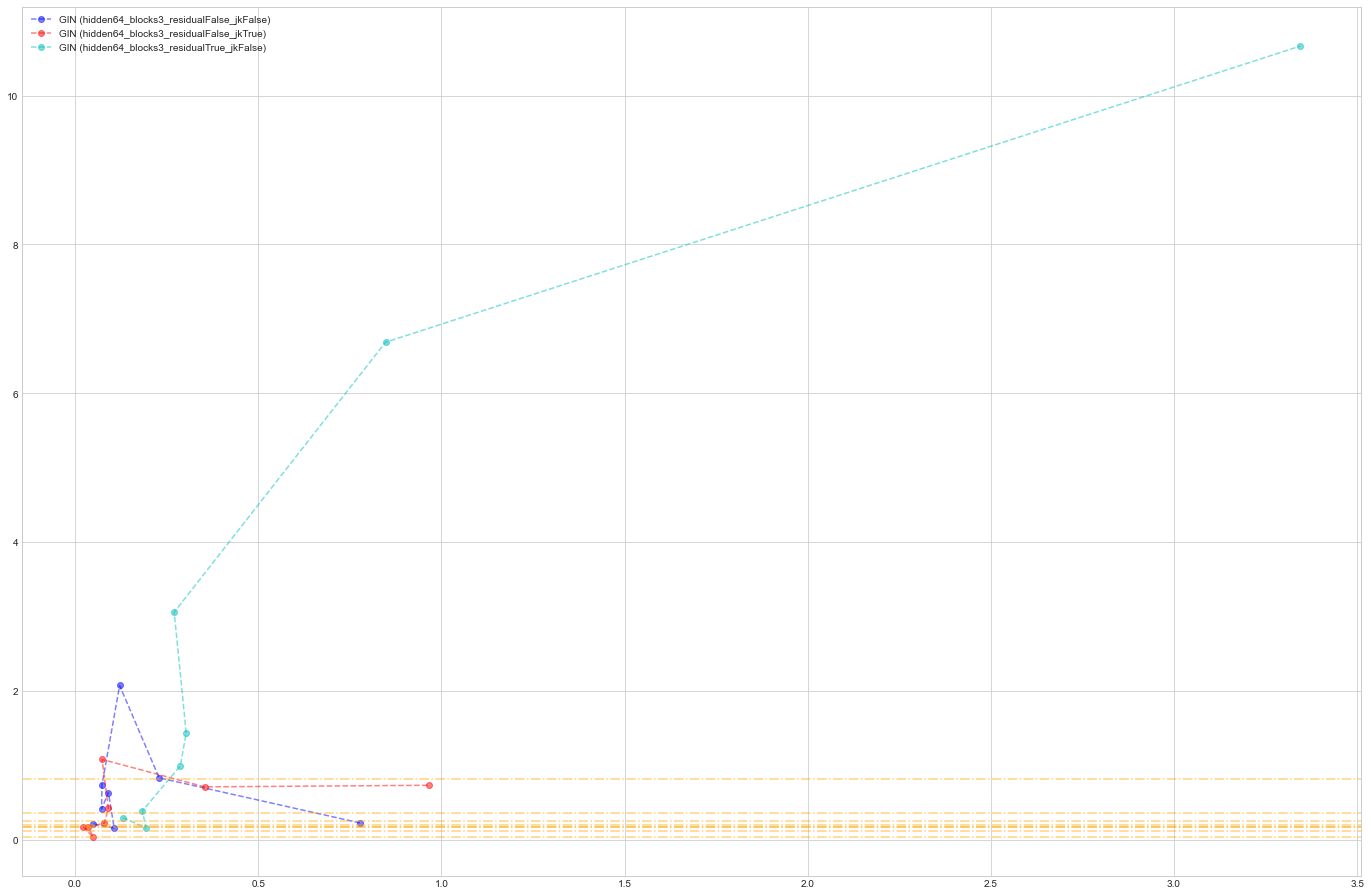

In [91]:
df = smoothness_stats_avg.groupby(['model', 'model_config']).agg(lambda x: list(x))
model_configs = df.index.unique().tolist()

colors = 'brc'
markers = 'oxd'
j = 0

fig, ax = plt.subplots(1, 1, figsize=(24, 16))

for model_config in model_configs:
    n = df.loc[model_config]['n']
    mean_smoothness = df.loc[model_config]['mean_smoothness']
    mean_rmse = df.loc[model_config]['mean_rmse']
    
    if model_config[0] == 'GIN':
        ax.plot(
            mean_rmse, mean_smoothness, color=colors[j], marker='o', ls='--', alpha=0.5,
            label=f"{model_config[0]} ({model_config[1].split('__init')[0]})"
        )
        j += 1
    elif model_config[0] == 'Real':
        for y in mean_smoothness:
            ax.axhline(y=y, color='orange', ls='-.', alpha=0.5)

ax.legend()    
plt.show()

### Generated with the same teacher & students
---

In [188]:
# Define some auxiliary functions for reading the generated smoothness csv files
def readSmoothnessCSV(smoothness_filename):
    '''Auxiliary function to read a generated smoothness csv file.'''
    smoothness_stats = pd.read_csv(smoothness_filename, header=[0, 1, 2], index_col=[0, 1])
    return smoothness_stats

In [189]:
teacher_outputs_prefix = \
    "../../data/synthetic/erdos_renyi/N110_n100_p0.1_1626075392/" \
    "teacher_outputs/regression/GIN/hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1"

# Retrieve different teacher output configurations
teacher_outputs_filenames = [x for x in os.listdir(teacher_outputs_prefix) if all([c.isdigit() for c in x])]
#teacher_outputs_configs = ['__'.join(x.split('__')[:-1]) for x in teacher_outputs_filenames]
# Make sure to work only with the same teacher configurations
#assert teacher_outputs_configs.count(teacher_outputs_configs[0]) == len(teacher_outputs_configs), \
#    'Please specify teacher configuration! (there are more than one configuration available)'
print(f"Results over {len(teacher_outputs_filenames)} different teacher initializations, using the folowing configuration:")
#print(teacher_outputs_filenames[0][:-15])
print('hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1')

# Retrieve available student models
students = set([
    x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/student_outputs') if x != '.DS_Store'
])
print()
print(f"Student outputs computed with the following models: {', '.join(students)}")

# Retrieve the different distance matrices used for computing the smoothness
dist_matrices = set()
for teacher_outputs_filename in teacher_outputs_filenames:
    dist_matrix_smoothness = [
        x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness') 
        if x.endswith('.csv')
    ]
    for dist_matrix in dist_matrix_smoothness:
        dist_matrices.add(dist_matrix.rstrip('.csv'))
print()
print(f"Smoothness computed with the following distance matrices: {', '.join(dist_matrices)}")

Results over 10 different teacher initializations, using the folowing configuration:
hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1

Student outputs computed with the following models: GIN, Baseline

Smoothness computed with the following distance matrices: WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64


In [190]:
import json

TEACHER_CONFIG = 'hidden32_blocks3_residualFalse_jkTrue__initUniform_bias0.0_lower-0.1_upper0.1'
DIST_MATRIX = 'WL__hashing__d3_iOnes__dist_matrices__hamming__sMaxdegree__train__full64'

# Gather all results for a given fixed teacher parameterization and a fixed distance matrix for computing the smoothness
smoothness_stats = pd.DataFrame()
for teacher_outputs_filename in teacher_outputs_filenames:
    student_outputs_filename = \
        f"{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness/{DIST_MATRIX}.csv"
    smoothness_stats = smoothness_stats.append(
        readSmoothnessCSV(student_outputs_filename), ignore_index=False)


# Filter only extrapolation data
smoothness_stats = smoothness_stats.iloc[:, smoothness_stats.columns.get_level_values(1) == 'extrapolation']
smoothness_stats.columns = smoothness_stats.columns.droplevel(1)
smoothness_stats = smoothness_stats.iloc[:, smoothness_stats.columns.get_level_values(1).isin(['mean_smoothness', 'mean_rmse'])]
smoothness_stats_ = smoothness_stats.copy()
smoothness_stats_ = smoothness_stats_.iloc[:, smoothness_stats_.columns.get_level_values(0) == '10']
smoothness_stats_.columns = smoothness_stats_.columns.droplevel(0)
smoothness_stats_.loc[smoothness_stats_.index.get_level_values(0).isin(['Real', 'Baseline']), ['mean_smoothness', 'mean_rmse']] = \
    smoothness_stats.loc[smoothness_stats.index.get_level_values(0).isin(['Real', 'Baseline']), smoothness_stats.columns.get_level_values(0) == '0'].droplevel(0, axis=1)
smoothness_stats_ = smoothness_stats_.reset_index().rename(columns={'level_0': 'model', 'level_1': 'model_config'})

def combineStringArrays(arr):
    ''''''
    for i in range(len(arr)):
        arr[i] = np.array([
            float(x) for x in arr[i].replace('\n', '').strip('[ ]').replace(',', ' ').split()
        ])
    return np.array(arr)
  
smoothness_stats_avg = smoothness_stats_.groupby(['model', 'model_config']).agg(lambda x: list(x))
# Convert string arrays
smoothness_stats_avg['mean_smoothness'] = smoothness_stats_avg['mean_smoothness'].apply(lambda x: combineStringArrays(x))
smoothness_stats_avg['mean_rmse'] = smoothness_stats_avg['mean_rmse'].apply(lambda x: combineStringArrays(x))
# Compute averages
smoothness_stats_avg['mean_smoothness'] = smoothness_stats_avg['mean_smoothness'].apply(lambda x: x.mean(0))
smoothness_stats_avg['mean_rmse'] = smoothness_stats_avg['mean_rmse'].apply(lambda x: x.mean(0))

smoothness_stats_avg

mean_smoothness  \
model    model_config                                                                                            
Baseline WL__hashing__d3_iOnes__dist_matrices__hamming__...  [0.0005256122064567252, 0.0005708829443201033,...   
GIN      hidden64_blocks3_residualFalse_jkFalse__initUni...  [0.12060525842182998, 0.17563508782525, 0.1819...   
         hidden64_blocks3_residualFalse_jkTrue__initUnif...  [0.050918172, 0.06626396, 0.073802212, 0.15383...   
         hidden64_blocks3_residualTrue_jkFalse__initUnif...  [0.10710344838000001, 0.14544001836, 0.2301746...   
Real                                                         [0.045262753431879715, 0.05778883681609196, 0....   

                                                                                                     mean_rmse  
model    model_config                                                                                           
Baseline WL__hashing__d3_iOnes__dist_matrices__hamming__...  [0.07080466102972555, 0.1046321522241902, 0.14...  
GIN      hidden64_blocks3_residualFalse_jkFalse__initUni...  [0.12496594800000001, 0.128167702, 0.162972457...  
         hidden64_blocks3_residualFalse_jkTrue__initUnif...  [0.13013813100000002, 0.13056974300000004, 0.1...  
         hidden64_blocks3_residualTrue_jkFalse__initUnif...  [0.444937644, 0.5192417020000001, 0.7561703160...  
Real                                                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

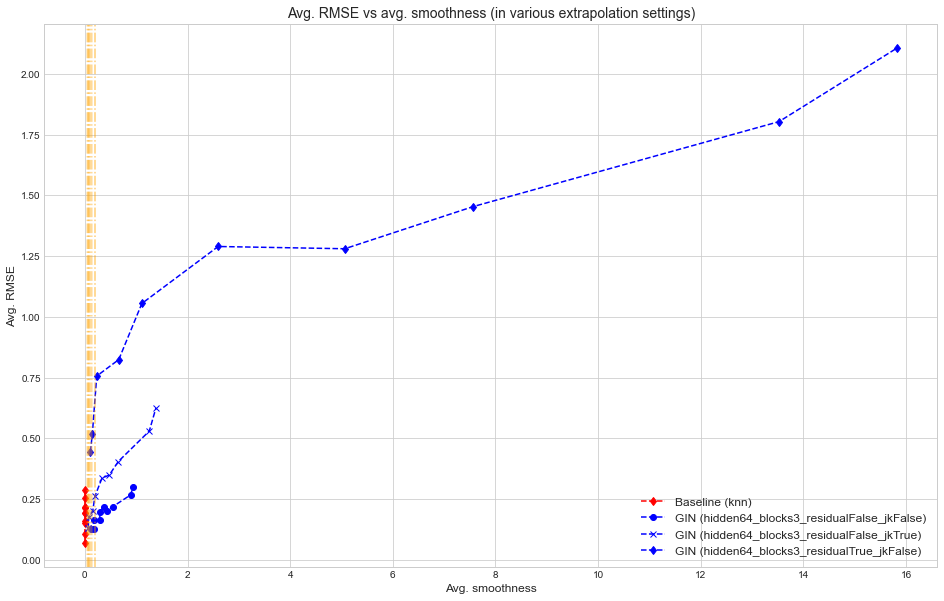

In [200]:
model_configs = smoothness_stats_avg.index.unique().tolist()

colors = 'brc'
markers = 'oxd'
j = 0

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

for model_config in model_configs:
    mean_smoothness = smoothness_stats_avg.loc[model_config]['mean_smoothness']
    mean_rmse = smoothness_stats_avg.loc[model_config]['mean_rmse']
    
    if model_config[0] == 'GIN':
        ax.plot(
            mean_smoothness, mean_rmse, color='b', marker=markers[j], ls='--', alpha=1,
            label=f"{model_config[0]} ({model_config[1].split('__init')[0]})"
        )
        j += 1
    elif model_config[0] == 'Real':
        for x in mean_smoothness:
            ax.axvline(x=x, color='orange', ls='-.', alpha=0.3)
    elif model_config[0] == 'Baseline':
        ax.plot(
            mean_smoothness, mean_rmse, color='r', marker='d', ls='--', alpha=1,
            label="Baseline (knn)"
        )

ax.set_title('Avg. RMSE vs avg. smoothness (in various extrapolation settings)', fontsize=14)
ax.set_xlabel('Avg. smoothness', fontsize=12)
ax.set_ylabel('Avg. RMSE', fontsize=12)
ax.legend(prop={'size': 12})    
plt.show()

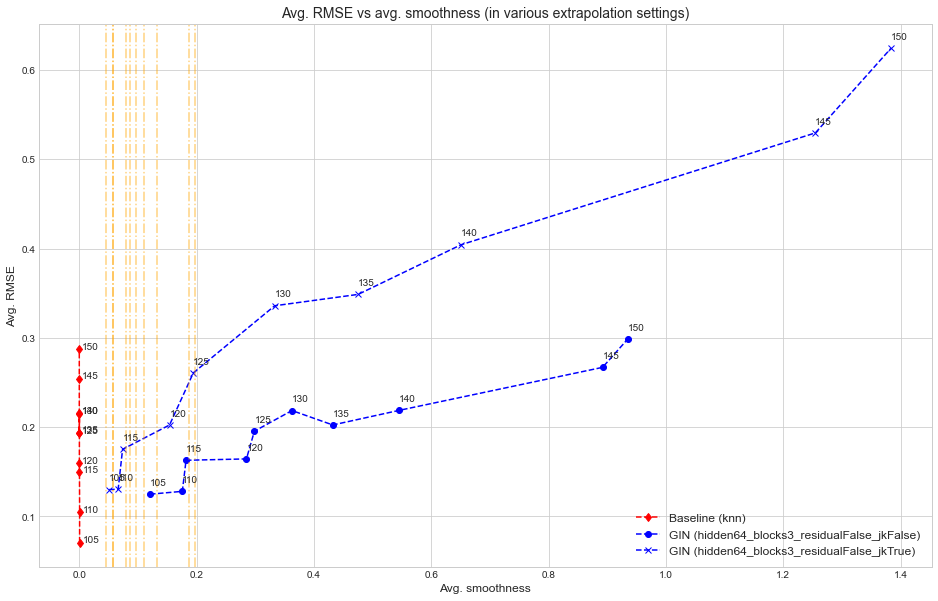

In [202]:
model_configs = smoothness_stats_avg.index.unique().tolist()

colors = 'brc'
markers = 'oxd'
j = 0


N_SIZES = list(map(int, 100 * np.arange(1.05, 1.55, 0.05)))

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

for model_config in model_configs:
    mean_smoothness = smoothness_stats_avg.loc[model_config]['mean_smoothness']
    mean_rmse = smoothness_stats_avg.loc[model_config]['mean_rmse']
    
    if model_config[0] == 'GIN':
        if 'residualTrue' not in model_config[1]:
            ax.plot(
                mean_smoothness, mean_rmse, color='b', marker=markers[j], ls='--', alpha=1,
                label=f"{model_config[0]} ({model_config[1].split('__init')[0]})"
            )
            for i, txt in enumerate(N_SIZES):
                ax.annotate(txt, (mean_smoothness[i], mean_rmse[i] + 0.01))
            j += 1
    elif model_config[0] == 'Real':
        for x in mean_smoothness:
            ax.axvline(x=x, color='orange', ls='-.', alpha=0.5)
    elif model_config[0] == 'Baseline':
        ax.plot(
            mean_smoothness, mean_rmse, color='r', marker='d', ls='--', alpha=1,
            label="Baseline (knn)"
        )
        for i, txt in enumerate(N_SIZES):
            ax.annotate(txt, (mean_smoothness[i] + 0.005, mean_rmse[i]))

ax.set_title('Avg. RMSE vs avg. smoothness (in various extrapolation settings)', fontsize=14)
ax.set_xlabel('Avg. smoothness', fontsize=12)
ax.set_ylabel('Avg. RMSE', fontsize=12)
ax.legend(prop={'size': 12})    
plt.show()